Conda environment for this notebook
```yml
name: geo_py312
channels:
  - conda-forge
  - defaults
dependencies:
  - python=3.12
  - gdal=3.10
  - pip
  - bottleneck
  - dask
  - folium
  - geopandas
  - httpx
  - ipykernel
  - jupyter
  - jupyterlab
  - matplotlib
  - nbformat
  - numpy
  - pandas
  - planetary-computer
  - pyproj
  - pystac
  - pystac-client
  - rasterio
  - rioxarray
  - rtree
  - scipy
  - shapely
  - xarray
  - zarr
  - pip:
    - odc-stac>=0.4
```

In [31]:
import re
from datetime import datetime

from IPython.display import Image, display
from io import BytesIO

import httpx
import matplotlib.pyplot as plt
import numpy as np
import odc.stac
import pyproj
import pystac
import pystac_client
import planetary_computer
import rioxarray
import scipy.signal as signal
from rasterio.features import rasterize
from shapely.geometry import box, shape
from shapely.ops import transform

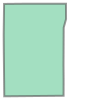

In [2]:
# get county boundary for any point
epsg = 4326
lat, lon = 41.79, -88.94

county_request = httpx.get(
    "https://tigerweb.geo.census.gov/arcgis/rest/services/Generalized_ACS2023/State_County/MapServer/13/query",
    params={
        "geometry": {"x": lon, "y": lat},
        "geometryType": "esriGeometryPoint",
        "inSR": {"wkid": epsg},
        "spatialRel": "esriSpatialRelIntersects",
        "f": "geoJSON",
    }
)

fc = county_request.json()
aoi = shape(fc["features"][0]["geometry"])
aoi

In [3]:
catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
)

In [4]:
HLS2_L30 = "hls2-l30"
HLS2_S30 = "hls2-s30"

collections = {
    collection_id: catalog.get_collection(collection_id)
    for collection_id in [HLS2_L30, HLS2_S30]
}

In [5]:
for collection_id, collection in collections.items():
    for key, asset in collection.extra_fields["item_assets"].items():
        if collection_id == HLS2_L30 and key == "B05":
            asset["eo:bands"][0]["common_name"] = "nir08"
        if collection_id == HLS2_S30 and key == "B8A":
            asset["eo:bands"][0]["common_name"] = "nir08"
        print(collection_id, key, asset["eo:bands"][0])

hls2-l30 B01 {'name': 'B01', 'common_name': 'coastal', 'center_wavelength': 0.48, 'full_width_half_max': 0.02}
hls2-l30 B02 {'name': 'B02', 'common_name': 'blue', 'center_wavelength': 0.44, 'full_width_half_max': 0.06}
hls2-l30 B03 {'name': 'B03', 'common_name': 'green', 'center_wavelength': 0.56, 'full_width_half_max': 0.06}
hls2-l30 B04 {'name': 'B04', 'common_name': 'red', 'center_wavelength': 0.65, 'full_width_half_max': 0.04}
hls2-l30 B05 {'name': 'B05', 'common_name': 'nir08', 'center_wavelength': 0.86, 'full_width_half_max': 0.03}
hls2-l30 B06 {'name': 'B06', 'common_name': 'swir16', 'center_wavelength': 1.6, 'full_width_half_max': 0.08}
hls2-l30 B07 {'name': 'B07', 'common_name': 'swir22', 'center_wavelength': 2.2, 'full_width_half_max': 0.2}
hls2-l30 B09 {'name': 'B09', 'common_name': 'cirrus', 'center_wavelength': 1.37, 'full_width_half_max': 0.02}
hls2-l30 B10 {'name': 'B10', 'common_name': 'lwir11', 'center_wavelength': 10.9, 'full_width_half_max': 0.8}
hls2-l30 B11 {'name'

In [6]:
hls_odc_stac_config = {
    collection_id: {
        "assets": {
            "*": {
                "nodata": -9999,
                "data_type": "int16",
            },
            "Fmask": {
                "nodata": 0,
                "data_type": "uint8",
            },
        },
        "aliases": {
            asset["eo:bands"][0]["common_name"]: key
            for key, asset in collection.extra_fields["item_assets"].items()
            if asset["eo:bands"][0].get("common_name")
        }
    }
    for collection_id, collection in collections.items()
}

In [13]:
datetime_range = [datetime(2024, 4, 1), datetime(2024, 11, 1)]
bbox = aoi.bounds
search = catalog.search(
    collections=[HLS2_L30, HLS2_S30],
    datetime=datetime_range,
    bbox=bbox,
)

hls_items = search.item_collection()
print(len(hls_items))

83


In [14]:
def group_by_sensor_and_date(
    item: pystac.Item,
    parsed: odc.stac.ParsedItem,
    idx: int,
) -> str:
    id_split = item.id.split(".")
    sensor = id_split[1]
    day = id_split[3][:7]

    return f"{sensor}_{day}"

In [69]:
# load the xarray Dataset in a CONUS-wide projected CRS
target_crs = "epsg:5070"
transformer = pyproj.Transformer.from_crs(
    crs_from=epsg,
    crs_to=target_crs,
    always_xy=True,
)

aoi_5070 = transform(transformer.transform, aoi)
bbox_5070 = aoi_5070.bounds

# these are the ones that we are going to use
bands = ["red", "green", "blue", "nir08", "swir16", "swir22", "Fmask"]

stack = odc.stac.load(
    hls_items,
    stac_cfg=hls_odc_stac_config,
    bands=bands,
    crs=target_crs,
    resolution=30,
    chunks={},
    groupby=group_by_sensor_and_date,
    x=(bbox_5070[0], bbox_5070[2]),
    y=(bbox_5070[1], bbox_5070[3]),
).sortby("time")
display(stack)

<xarray.Dataset> Size: 2GB
Dimensions:      (y: 2027, x: 1073, time: 83)
Coordinates:
  * y            (y) float64 16kB 2.152e+06 2.152e+06 ... 2.091e+06 2.091e+06
  * x            (x) float64 9kB 5.79e+05 5.79e+05 ... 6.111e+05 6.112e+05
    spatial_ref  int32 4B 5070
  * time         (time) datetime64[ns] 664B 2024-04-02T17:01:54.392140 ... 20...
Data variables:
    red          (time, y, x) int16 361MB dask.array<chunksize=(1, 2027, 1073), meta=np.ndarray>
    green        (time, y, x) int16 361MB dask.array<chunksize=(1, 2027, 1073), meta=np.ndarray>
    blue         (time, y, x) int16 361MB dask.array<chunksize=(1, 2027, 1073), meta=np.ndarray>
    nir08        (time, y, x) int16 361MB dask.array<chunksize=(1, 2027, 1073), meta=np.ndarray>
    swir16       (time, y, x) int16 361MB dask.array<chunksize=(1, 2027, 1073), meta=np.ndarray>
    swir22       (time, y, x) int16 361MB dask.array<chunksize=(1, 2027, 1073), meta=np.ndarray>
    Fmask        (time, y, x) uint8 181MB dask.array<chunksize=(1, 2027, 1073), meta=np.ndarray>

In [70]:
# geographic mask for the original AOI
aoi_mask = rasterize(
    [(aoi_5070, 1)],
    out_shape=(stack.rio.height, stack.rio.width),
    transform=stack.rio.transform(),
    fill=0,
    all_touched=True,
    dtype=np.uint8
).astype(bool)

In [71]:
sample_time_slice = slice("2024-07-01", None)
sample_time_idx_slice = slice(0, 6)

rgb_sample = (
    stack.to_dataarray(dim="band")
    .sel(
        time=sample_time_slice,
        band=["red", "green", "blue"]
    )
    .isel(time=sample_time_idx_slice)
    .where(aoi_mask)
    .compute()
)

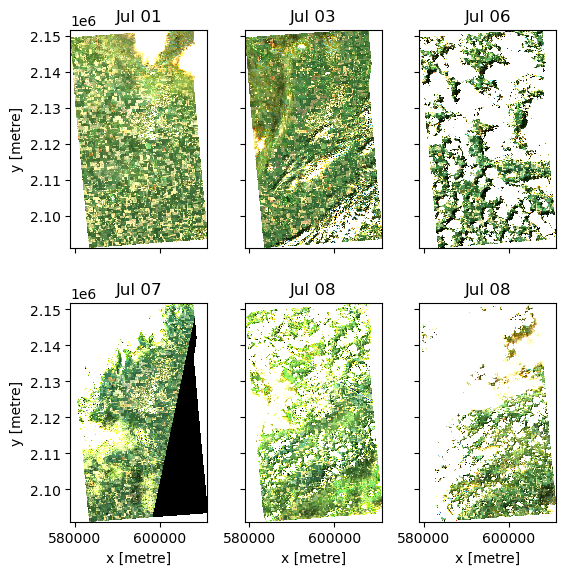

<Figure size 800x800 with 0 Axes>

In [72]:
plot_params = {
    "aspect": stack.rio.width / stack.rio.height,
    "col": "time",
    "col_wrap": 3,
    "robust": True,
    "add_labels": False,
}

rgb_plot = (
    rgb_sample
    .plot.imshow(
        rgb="band",
        vmin=0,
        vmax=1000,
        **plot_params,
    )
)

def show_plot(plot):
    for i, ax in enumerate(plot.axes.flat):
        title = ax.get_title()
        
        match = re.search(r'(\d{4}-\d{2}-\d{2})', title)
        if match:
            date_str = match.group(1)
            date_obj = datetime.strptime(date_str, '%Y-%m-%d')
            new_title = date_obj.strftime('%b %d')  # Format as "Jul 05"
            
            # Set the new title
            ax.set_title(new_title)

    plt.figure(figsize=(8, 8))
    plt.show(plot)

show_plot(rgb_plot)

In [73]:
# check for datetimes where the proportion of valid pixels is acceptable
hls_mask_bitfields = [1, 2, 3]  # cloud shadow, adjacent to cloud shadow, cloud
hls_bitmask = 0
for field in hls_mask_bitfields:
    hls_bitmask |= 1 << field

print(hls_bitmask)

14


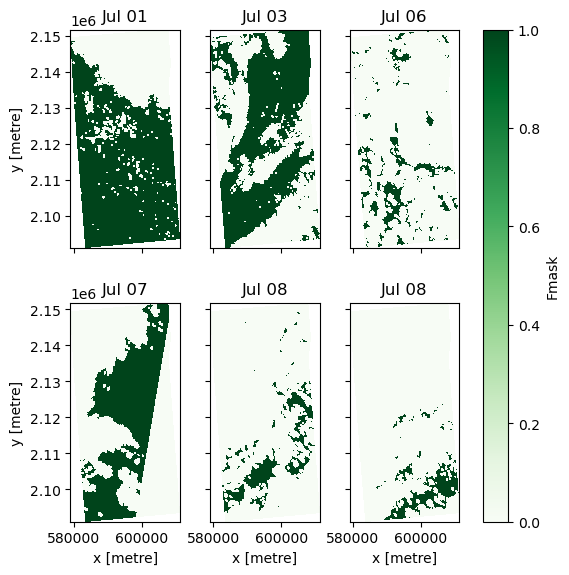

<Figure size 800x800 with 0 Axes>

In [74]:
fmask = stack["Fmask"].astype("uint16")
valid_mask = ((fmask & hls_bitmask) == 0).where(aoi_mask)
valid_plot = (
    valid_mask
    .sel(time=sample_time_slice)
    .isel(time=sample_time_idx_slice)
    .compute()
    .plot.imshow(
        vmin=0,
        vmax=1,
        cmap="Greens",
        **plot_params,
    )
)

show_plot(valid_plot)

In [75]:
valid_proportions = valid_mask.mean(dim=["x", "y"], skipna=True)

(
    valid_proportions
    .sel(time=sample_time_slice)
    .isel(time=sample_time_idx_slice)
    .compute()
)

<xarray.DataArray 'Fmask' (time: 6)> Size: 48B
array([0.67161962, 0.53758062, 0.09540152, 0.38621438, 0.09728009,
       0.07004714])
Coordinates:
    spatial_ref  int32 4B 5070
  * time         (time) datetime64[ns] 48B 2024-07-01T17:01:59.746320 ... 202...

In [76]:
valid_threshold = 0.5
valid_datetimes = (valid_proportions >= valid_threshold)

In [77]:
cloud_free_stack = (
    stack
    .where(valid_mask == 1)
    .sel(time=valid_datetimes)
)

cloud_free_stack

<xarray.Dataset> Size: 3GB
Dimensions:      (time: 47, y: 2027, x: 1073)
Coordinates:
  * y            (y) float64 16kB 2.152e+06 2.152e+06 ... 2.091e+06 2.091e+06
  * x            (x) float64 9kB 5.79e+05 5.79e+05 ... 6.111e+05 6.112e+05
    spatial_ref  int32 4B 5070
  * time         (time) datetime64[ns] 376B 2024-04-12T17:01:56.375150 ... 20...
Data variables:
    red          (time, y, x) float32 409MB dask.array<chunksize=(1, 2027, 1073), meta=np.ndarray>
    green        (time, y, x) float32 409MB dask.array<chunksize=(1, 2027, 1073), meta=np.ndarray>
    blue         (time, y, x) float32 409MB dask.array<chunksize=(1, 2027, 1073), meta=np.ndarray>
    nir08        (time, y, x) float32 409MB dask.array<chunksize=(1, 2027, 1073), meta=np.ndarray>
    swir16       (time, y, x) float32 409MB dask.array<chunksize=(1, 2027, 1073), meta=np.ndarray>
    swir22       (time, y, x) float32 409MB dask.array<chunksize=(1, 2027, 1073), meta=np.ndarray>
    Fmask        (time, y, x) float32 409MB dask.array<chunksize=(1, 2027, 1073), meta=np.ndarray>

In [78]:
cloud_free_rgb_sample = (
    cloud_free_stack.to_dataarray(dim="band")
    .sel(
        time=sample_time_slice,
        band=["red", "green", "blue"]
    )
    .isel(time=sample_time_idx_slice)
    .compute()
)

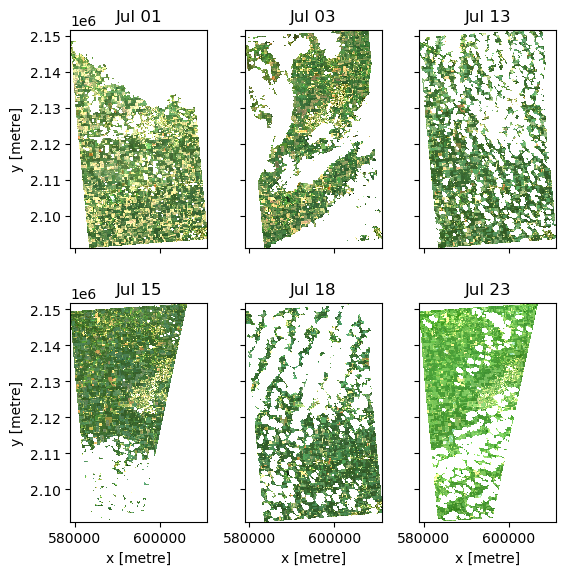

<Figure size 800x800 with 0 Axes>

In [79]:
cloud_free_plot = (
    cloud_free_rgb_sample
    .plot.imshow(
        rgb="band",
        vmin=0,
        vmax=1000,
        **plot_params,
    )
)

show_plot(cloud_free_plot)

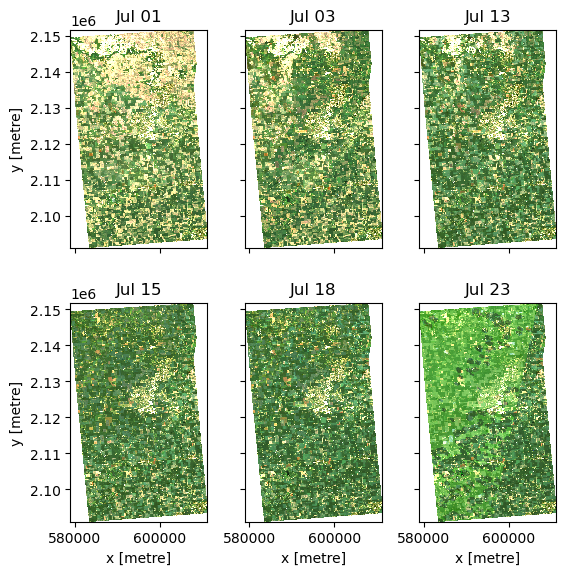

<Figure size 800x800 with 0 Axes>

In [80]:
cloud_free_rgb_sample_ffill = (
    cloud_free_stack.to_dataarray(dim="band")
    .ffill(dim="time")
    .sel(
        time=sample_time_slice,
        band=["red", "green", "blue"]
    )
    .isel(time=sample_time_idx_slice)
    .compute()
)

cloud_free_ffill_plot = (
    cloud_free_rgb_sample_ffill
    .plot.imshow(
        rgb="band",
        vmin=0,
        vmax=1000,
        **plot_params,
    )
)

show_plot(cloud_free_ffill_plot)

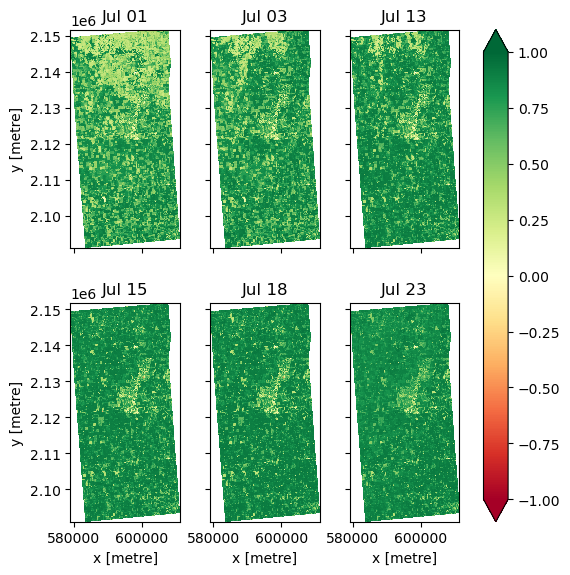

<Figure size 800x800 with 0 Axes>

In [81]:
ndvi = (cloud_free_stack["nir08"] - cloud_free_stack["red"]) / (cloud_free_stack["nir08"] + cloud_free_stack["red"])

ndvi_sample_ffill = (
    ndvi
    .ffill(dim="time")
    .sel(
        time=sample_time_slice,
    )
    .isel(time=sample_time_idx_slice)
    .compute()
)

ndvi_plot = (
    ndvi_sample_ffill
    .plot.imshow(
        vmin=-1,
        vmax=1,
        cmap="RdYlGn",
        **plot_params,
    )
)

show_plot(ndvi_plot)

In [85]:
global_ndvi = (
    ndvi
    .mean(dim=["x", "y"], skipna=True)
    .chunk({"time": -1})
    .interpolate_na(dim="time", method="linear", limit=3)
    .compute()
)
global_ndvi

<xarray.DataArray (time: 47)> Size: 188B
array([0.31247598, 0.35069197, 0.4485132 , 0.46041533, 0.4828192 ,
       0.7353238 , 0.7767886 , 0.8319039 , 0.812546  , 0.84664047,
       0.8182925 , 0.8171509 , 0.8478767 , 0.85449666, 0.8658548 ,
       0.85194415, 0.8307994 , 0.8353184 , 0.8157155 ,       -inf,
       0.8169347 , 0.75186396, 0.7741878 , 0.7176606 , 0.74538064,
       0.5945289 ,        inf, 0.5166    ,       -inf, 0.49175736,
       0.4314363 , 0.4202728 , 0.41362602, 0.45723516, 0.4037269 ,
       0.40181753, 0.3575086 , 0.39219075, 0.34960446,       -inf,
       0.34422883, 0.32499117,       -inf,       -inf,       -inf,
       0.31268144, 0.33059615], dtype=float32)
Coordinates:
    spatial_ref  int32 4B 5070
  * time         (time) datetime64[ns] 376B 2024-04-12T17:01:56.375150 ... 20...

In [60]:
# Smooth the time series to reduce noise
# Convert to numpy array for smoothing
ndvi_values = global_ndvi.values
smooth_ndvi = signal.savgol_filter(ndvi_values, window_length=5, polyorder=2)
smooth_ndvi

array([0.30311817, 0.37035546, 0.4228075 , 0.45393416, 0.5143088 ,
       0.6255563 , 0.7428308 , 0.7943972 , 0.82508826, 0.8294362 ,
       0.8251275 , 0.8269713 , 0.839635  , 0.8585794 , 0.8609411 ,
       0.85350823, 0.8426211 ,        inf,       -inf,       -inf,
             -inf,        inf, 0.7532134 , 0.75149024,       -inf,
              inf,        inf,        nan,       -inf,       -inf,
              inf, 0.41244054, 0.4245666 , 0.42506918, 0.41859096,
       0.38994157, 0.38753107,        inf,       -inf,       -inf,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan], dtype=float32)

In [ ]:

# Find peaks and troughs to identify growth stages
peaks, _ = signal.find_peaks(smooth_ndvi, height=0.3, distance=10)
growth_stage_dates = global_ndvi.time.values[peaks]

In [59]:
growth_stage_dates

array(['2024-07-18T16:52:03.263080000', '2024-09-09T16:40:46.397241000',
       '2024-10-11T16:51:57.826990000'], dtype='datetime64[ns]')